In [1]:
%reload_ext autoreload
%autoreload 
%matplotlib inline

In [2]:
# import os

# df = pd.read_csv('/content/gdrive/My Drive/app/data/AV/test.csv')

# for i in range(len(df)):
#   if(os.path.isfile("/content/gdrive/My Drive/app/data/AV/images/"+df.loc[i, "image_names"])):
#     os.rename("/content/gdrive/My Drive/app/data/AV/images/"+df.loc[i, "image_names"], "/content/gdrive/My Drive/app/data/AV/test/"+df.loc[i, "image_names"])
#     print(i)

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'AV/'

Mounted at /content/gdrive


In [4]:
from fastai.vision import *
from fastai.callbacks import *
import numpy as np
from fastai.widgets import *

In [5]:
#!pip install "torch==1.4" "torchvision==0.5.0"

In [6]:
sizes = [32, 64, 128, 224]
flg_grey = False
#additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=True),contrast(scale=(1.2,1.2) ) ] # *zoom_crop(scale=(0.75,1.25), do_rand=True),
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10,max_zoom=0.4,max_lighting=0.3,max_warp=0.3)
batch =128

np.random.seed(60) # cpu vars
torch.manual_seed(60) # cpu  vars

def get_data(sz, bs):
  data = ImageDataBunch.from_csv(path=('/content/gdrive/My Drive/app/data/AV'), 
                                folder='.', test = 'test', csv_labels='cleaned_dup.csv', valid_pct=0.18, fn_col=0, label_col=1, header=1, ds_tfms = get_transforms(),
                                 size = sz, bs = bs).normalize(imagenet_stats)

  
  # data = (ImageDataBunch.from_csv(path='/content/gdrive/My Drive/app/data/AV', folder='images')
  # .split_none()   #split_none()
  # .label_from_df(cols='emergency_or_not')
  # #.add_test_folder( '/content/gdrive/My Drive/Veh_Data/app/data/AV/test')
  # .transform(get_transforms(), size= (sz,sz))
  # .databunch(bs=bs).normalize(imagenet_stats))

  

  if flg_grey:
    for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
      itemList = getattr(data, itemList)
      if itemList: itemList.x.convert_mode = "L"
  
  return data

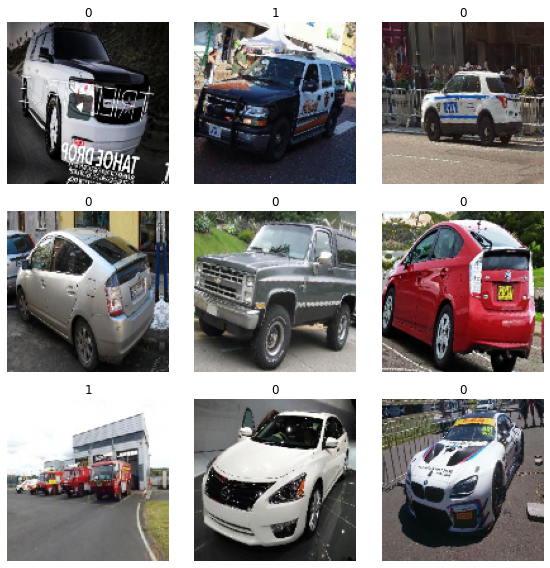

In [7]:
np.random.seed(60)

data=get_data(sizes[2],128)
data.show_batch(rows=3, figsize=(8,8))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.test_ds)

([0, 1], 2, 1267, 706)

In [8]:
learn = cnn_learner(data, models.resnet50, metrics= error_rate ,bn_final=True).mixup()  #Try Mixup model
mod_name = 'veh_res101_1'
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.618330,0.655516,0.148014,00:16
1,0.525644,0.569484,0.169675,00:10
2,0.483847,0.346280,0.148014,00:10
3,0.457249,0.288841,0.148014,00:10
4,0.440663,0.274339,0.151625,00:10


In [19]:
# learn.load('veh_res101_1')
# learn.data=data

In [16]:
# ds, idxs = DatasetFormatter().from_similars(learn)
# ImageCleaner(ds, idxs, path="/content/gdrive/My Drive/app/data/AV")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.02E-04


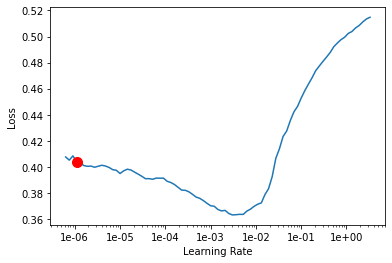

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# learn = cnn_learner(data, models.resnet152, metrics= error_rate ,bn_final=True).mixup().load(mod_name)
# learn.data = data
# learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,0.397293,0.272484,0.151625,00:11
1,0.402306,0.260333,0.137184,00:12
2,0.398192,0.251355,0.115523,00:12
3,0.388588,0.258211,0.129964,00:12
4,0.386535,0.259630,0.129964,00:11
5,0.383846,0.251010,0.126354,00:12
6,0.379326,0.251170,0.126354,00:11


Better model found at epoch 0 with error_rate value: 0.15162454545497894.
Better model found at epoch 1 with error_rate value: 0.13718411326408386.
Better model found at epoch 2 with error_rate value: 0.11552346497774124.


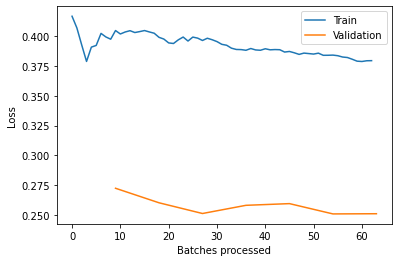

In [10]:
mod_name2= 'veh_res_2'
learn.fit_one_cycle(7,max_lr = slice(1e-6,1e-3/5),callbacks=[SaveModelCallback(learn,monitor='error_rate',mode='min',every='improvement',name=mod_name2)])
learn.recorder.plot_losses()

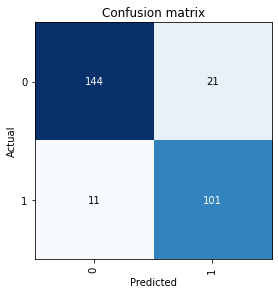

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [10]:
#learn = cnn_learner(data, models.resnet50, metrics= error_rate ,bn_final=True).mixup().load('veh_res_2')

data = get_data(sizes[3],64)
learn.data=data
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 5.75E-03


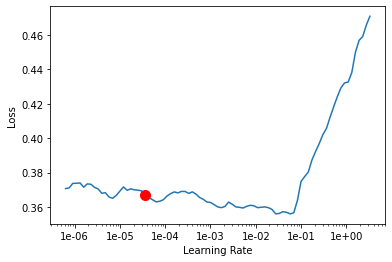

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.368952,0.185467,0.079422,00:30
1,0.360691,0.168375,0.083032,00:21
2,0.343736,0.175639,0.079422,00:21
3,0.330122,0.169792,0.083032,00:21
4,0.323094,0.172485,0.086643,00:21


In [12]:
learn.save('pre_mod')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 6.31E-08


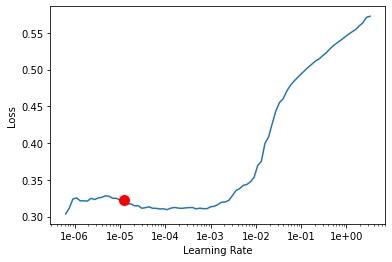

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.308306,0.172872,0.083032,00:28
1,0.311886,0.171004,0.079422,00:28
2,0.302144,0.169578,0.083032,00:28
3,0.295893,0.171556,0.083032,00:28
4,0.292167,0.171213,0.086643,00:28
5,0.292118,0.173194,0.079422,00:28


Better model found at epoch 0 with error_rate value: 0.08303248882293701.
Better model found at epoch 1 with error_rate value: 0.07942238450050354.


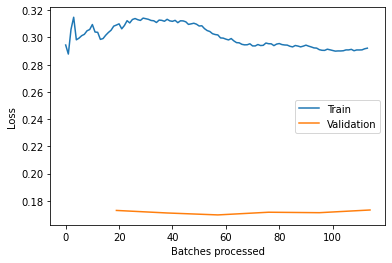

In [14]:
# data = get_data(sizes[3],32)
# learn = cnn_learner(data, models.resnet152, metrics=error_rate,bn_final=True).mixup().load('veh_res_4')
# learn.data=data
 
final_mod = 'veh_res_5'
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4),callbacks=[SaveModelCallback(learn,monitor='error_rate',mode='min',every='improvement',name=final_mod)])
learn.recorder.plot_losses()

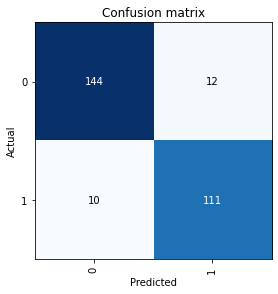

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [35]:
# ds, idxs = DatasetFormatter().from_toplosses(learn)
# ImageCleaner(ds, idxs,  path="/content/gdrive/My Drive/app/data/AV")

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [16]:
learn.export()
fnames = [str(x)[str(x).rfind('/')+1:] for x in data.test_ds.items[:]]

In [19]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)  
#preds, _ = learn.TTA(ds_type=DatasetType.Test) #TTA performs better

labels = np.argmax(preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

In [21]:
df_final = pd.DataFrame(list(zip(fnames, test_predictions_direct)),  columns =['image_names', 'emergency_or_not']) 
df_final.to_csv('/content/gdrive/My Drive/app/data/AV/Vehicle_submission.csv', index=False)